## Starting with Michael Wood-Vasey's notebook as a starting point
## Craig Lage - 28Aug18

## Make a brighter-fatter kernel from a set of high-intensity flats measured at UC Davis.
## Run correlations by amplifier.  Now adding more flat pairs

This notebook shows extracting the BF kernel from a set of measured flats.

So far, this notebook is only runnable on the system at UC Davis.  

Before it can be run at NCSA, two things need to happen:

     (1) I need to upolad the fits files for the flats.  Easily done.
     (2) I need to understand how to run at NCSA when not using a released version of the stack.  
     The code currently requires several branches which are not released in the stack, 
     as detailed below.

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib


lsst_distrib          16.0+3     	current w_2018_26 setup


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# if running stack v16.0, silence a long matplotlib Agg warning with:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
# Test to make sure that we can import obs_lsstCam
import lsst.obs.base
import lsst.obs.lsstCam

In [5]:
from lsst.cp.pipe.makeBrighterFatterKernel import MakeBrighterFatterKernelTask
from lsst.daf.persistence import Butler
from lsst.pipe.tasks.ingest import IngestTask

In [5]:
!pwd

/sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks


## Ingest 25 pairs of flats from UC Davis measurements

In [6]:
!ls /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_100_20180514??????.fits

/mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_100_20180514141655.fits


In [6]:
# Don't need to run this each time
!rm -rf ucd_repo_2
! mkdir ucd_repo_2
! echo "lsst.obs.lsstCam.LsstCamMapper" > ucd_repo_2/_mapper

# Ingest the  flats. The ?00 and ?01 are the flat pairs
! ingestImages.py ucd_repo_2 /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_?0?_20180514??????.fits --mode link

root INFO: Loading config overrride file '/sandbox/cslage/Research/LSST/code/w_2018_26/obs_lsstCam/config/ingest.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading Posix exposure registry from /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo_2
ingest INFO: /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_100_20180514141655.fits --<link>--> /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo_2/raw/100/R21/00000100-R21-S11-det085-000.fits
ingest INFO: /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_101_20180514141706.fits --<link>--> /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo_2/raw/101/R21/00000101-R21-S11-det085-000.fits
ingest INFO: /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_102_20180514141718.fits --<link>--> /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo_2/raw/102/R21/00000102-R21-S11-det085-000.fits
ingest INFO: /

In [5]:
butler = Butler('ucd_repo_2')


So I got this far, and it has successfully ingested the images.  So far, all I have done is:

     (1) Copied MWV code and hacks as closely as I could.
         (A) Using w_2018_26
         (B) obs_base tickets/DM-13293
         (C) obs_lsstCam tickets/DM-15509
         (D) cp_pipe tickets/DM-13293
         (E) Comment out the `exposure.setWcs` command in the raw assembly in `obs_lsstCam`.
         (F) Define a wrapper `run` method in `makeBrighterFatterTask.py` that calls `runDataRef`.
         (G) Comment out from .cpTask import * in the `cp_pipe/python/lsst/cp/pipe/__init__.py` file.

     (2) edit obs_lsstCam/config/ingest.py to use some different header values
     (3) edit obs_lsstCam/python/lsst/obs/lsstCam/ingest.py to work with these different values and 
     to fudge the raft and sensor IDs.


In [6]:
print(butler.queryMetadata('src', ['visit', 'detector', 'filter', 'id', 'raftName', 'detectorName']))
# Note that the 'detector' value is 85, and I have hacked the CCD to be R21:S11

[(100, 85, 'r', 1, 'R21', 'S11'), (101, 85, 'r', 2, 'R21', 'S11'), (102, 85, 'r', 3, 'R21', 'S11'), (103, 85, 'r', 4, 'R21', 'S11'), (104, 85, 'r', 5, 'R21', 'S11'), (105, 85, 'r', 6, 'R21', 'S11'), (106, 85, 'r', 7, 'R21', 'S11'), (107, 85, 'r', 8, 'R21', 'S11'), (108, 85, 'r', 9, 'R21', 'S11'), (109, 85, 'r', 10, 'R21', 'S11'), (200, 85, 'r', 11, 'R21', 'S11'), (201, 85, 'r', 12, 'R21', 'S11'), (202, 85, 'r', 13, 'R21', 'S11'), (203, 85, 'r', 14, 'R21', 'S11'), (204, 85, 'r', 15, 'R21', 'S11'), (205, 85, 'r', 16, 'R21', 'S11'), (206, 85, 'r', 17, 'R21', 'S11'), (207, 85, 'r', 18, 'R21', 'S11'), (208, 85, 'r', 19, 'R21', 'S11'), (209, 85, 'r', 20, 'R21', 'S11'), (300, 85, 'r', 21, 'R21', 'S11'), (301, 85, 'r', 22, 'R21', 'S11'), (302, 85, 'r', 23, 'R21', 'S11'), (303, 85, 'r', 24, 'R21', 'S11'), (304, 85, 'r', 25, 'R21', 'S11'), (305, 85, 'r', 26, 'R21', 'S11'), (306, 85, 'r', 27, 'R21', 'S11'), (307, 85, 'r', 28, 'R21', 'S11'), (308, 85, 'r', 29, 'R21', 'S11'), (309, 85, 'r', 30, 'R2

In [7]:
# Put in the approximate measured gain values
amp_names = ['C{:02d}'.format(i) for i in range(18)]
ucd_gain = 4.5
nominalGain = {a: ucd_gain for a in amp_names}
gain = nominalGain
dataRef = butler.dataRef('brighterFatterGain', dataId={'detector': 85}) 
dataRef.put(gain, 'brighterFatterGain')

In [8]:
pairs = []
for firstDigit in range(1,6):
    for lastDigit in range(5):
        pairs.append('%s,%s'%(str(100*firstDigit+2*lastDigit),str(100*firstDigit+2*lastDigit+1)))
    
print(pairs)

['100,101', '102,103', '104,105', '106,107', '108,109', '200,201', '202,203', '204,205', '206,207', '208,209', '300,301', '302,303', '304,305', '306,307', '308,309', '400,401', '402,403', '404,405', '406,407', '408,409', '500,501', '502,503', '504,505', '506,507', '508,509']


Now try calculating the brighter-fatter kernel using `MakeBrighterFatterKernelTask`. By setting level='AMP', we force amplifier by amplifier calculations. The first attempt was with assumed gains.

Now repeating it with calculated gains.  I needed to make some edits to prevent it from exiting on the bad amps.
This processing took several hours.

In [9]:
args = ['ucd_repo_2', '--rerun', 'test',
        '--id', 'detector=85',
        '--visit-pairs', '100,101', '102,103', '104,105', '106,107', '108,109', '200,201', '202,203', '204,205', '206,207', '208,209', '300,301', '302,303', '304,305', '306,307', '308,309', '400,401', '402,403', '404,405', '406,407', '408,409', '500,501', '502,503', '504,505', '506,507', '508,509',
        '-c',
        'xcorrCheckRejectLevel=2', 'doCalcGains=True', 'level="AMP"',
        '--clobber-config', '--clobber-versions'
       ]

command_line = 'makeBrighterFatterKernel.py ' + ' '.join(args)
print(command_line)

ucd_pb_struct = MakeBrighterFatterKernelTask.parseAndRun(args=args)

makeBrighterFatterKernel.py ucd_repo_2 --rerun test --id detector=85 --visit-pairs 100,101 102,103 104,105 106,107 108,109 200,201 202,203 204,205 206,207 208,209 300,301 302,303 304,305 306,307 308,309 400,401 402,403 404,405 406,407 408,409 500,501 502,503 504,505 506,507 508,509 -c xcorrCheckRejectLevel=2 doCalcGains=True level="AMP" --clobber-config --clobber-versions
Finished image preparation for visit  100 101
Finished cross-correlation for  C10  in visit  100 101
Finished cross-correlation for  C11  in visit  100 101
Finished cross-correlation for  C12  in visit  100 101
Finished cross-correlation for  C13  in visit  100 101
Finished cross-correlation for  C14  in visit  100 101
Finished cross-correlation for  C15  in visit  100 101
Finished cross-correlation for  C16  in visit  100 101
Finished cross-correlation for  C17  in visit  100 101
Finished cross-correlation for  C07  in visit  100 101
Finished cross-correlation for  C06  in visit  100 101
Finished cross-correlation fo

In [6]:
#It now runs with doCalcGains=True and the gains are close to what we measured here.
ucd_detector = 85
test_butler = Butler('ucd_repo_2/rerun/test')
ucd_bf_kernel = test_butler.get('brighterFatterKernelNew', dataId={'raftName': 'R21', 'detectorName': 'S11', 'detector': ucd_detector})
gain_data = test_butler.get('brighterFatterGain', dataId={'raftName': 'R21', 'detectorName': 'S11', 'detector': 85})

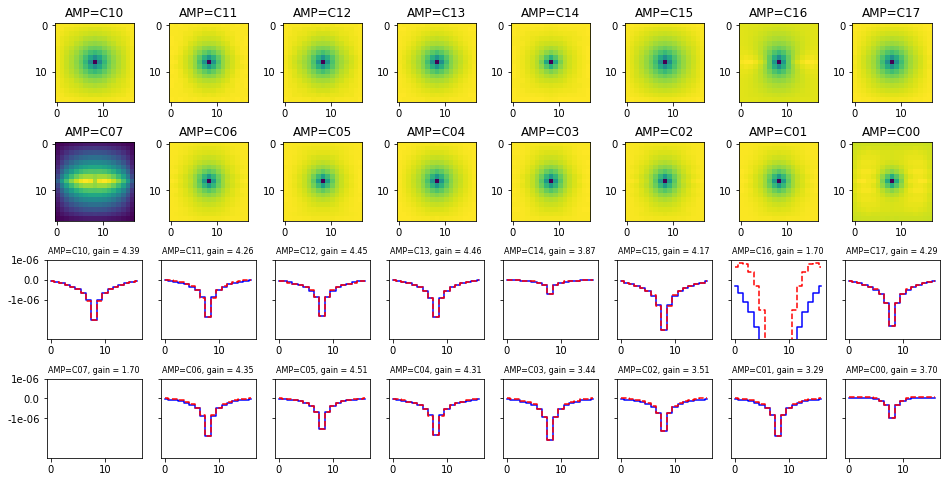

In [7]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.5)
for i, key in enumerate(ucd_bf_kernel.keys()):
    plt.subplot(4,8,i+1)
    plt.title('AMP=%s'%key) 
    plt.imshow(ucd_bf_kernel[key])
    ax1 = plt.subplot(4,8,i+17)
    ax1.set_title('AMP=%s, gain = %.2f'%(key,gain_data[key]),fontsize = 8) 
    ax1.set_ylim(-3.0E-6,1.0E-6)
    ax1.set_yticks([-1.0E-6, 0.0,1.0E-6])
    ax1.plot(ucd_bf_kernel[key][:,8], color='blue', drawstyle='steps-mid')
    ax1.plot(ucd_bf_kernel[key][8,:], linestyle='--', color='red', drawstyle='steps-mid')

    if (i == 0 or i == 8):
        ax1.set_yticklabels([-1.0E-6, 0.0,1.0E-6])
    else:
        ax1.set_yticklabels([])
        

plt.savefig('BF_Kernel_25_Pairs_28Aug18.pdf')
plt.show()

Now read in the kernel that I calculated with my code (BF_Kernel_Correction_07Jun18.ipynb) for comparison.

In [15]:
#Reading in the kernel that I calculated here.

from pylab import *
import pickle as pkl
class Array2d:
    def __init__(self,xmin,xmax,nx,ymin,ymax,ny):
        # Each image is nx * ny pixels
        self.nx=nx
        self.ny=ny

        self.xmin=xmin
        self.ymin=ymin
        
        self.xmax=xmax
        self.ymax=ymax
        
        self.dx=(xmax-xmin)/nx
        self.dy=(ymax-ymin)/ny
        
        self.x=linspace(xmin+self.dx/2,xmax-self.dx/2,nx)
        self.y=linspace(ymin+self.dy/2,ymax-self.dy/2,ny)

        self.cov=zeros([nx,ny])
        self.kernel=zeros([nx,ny])       
        
    def PrintKernel(self, filename):
        file = open(filename, 'w')
        line = 'X\tY\tCovariance\t\t\tKernel\n'
        file.write(line)
        for i in range(self.nx):
            for j in range(self.ny):
                line = '%d\t%d\t%0.12e\t%0.12e\n'%(i,j,self.cov[i,j],self.kernel[i,j])
                file.write(line)
        file.close()
        return

    def ReadKernel(self, filename):
        file = open(filename, 'r')
        lines = file.readlines()
        file.close()
        lines.remove(lines[0])
        for line in lines:
            items = line.split()
            i = int(items[0])
            j = int(items[1])
            cov = float(items[2])
            ker = float(items[3])
            self.cov[i,j] = cov
            self.kernel[i,j] = ker
        return

NewNx = NewNy = 21
kernel = Array2d(0,NewNx,NewNx,0,NewNy,NewNy)
my_kernel_filename = "/home/cslage/Research/LSST/code/notebooks/best_kernel/kernel_model_central_csteps_7_07jun18.txt"
kernel.ReadKernel(my_kernel_filename)
#print(kernel.kernel)


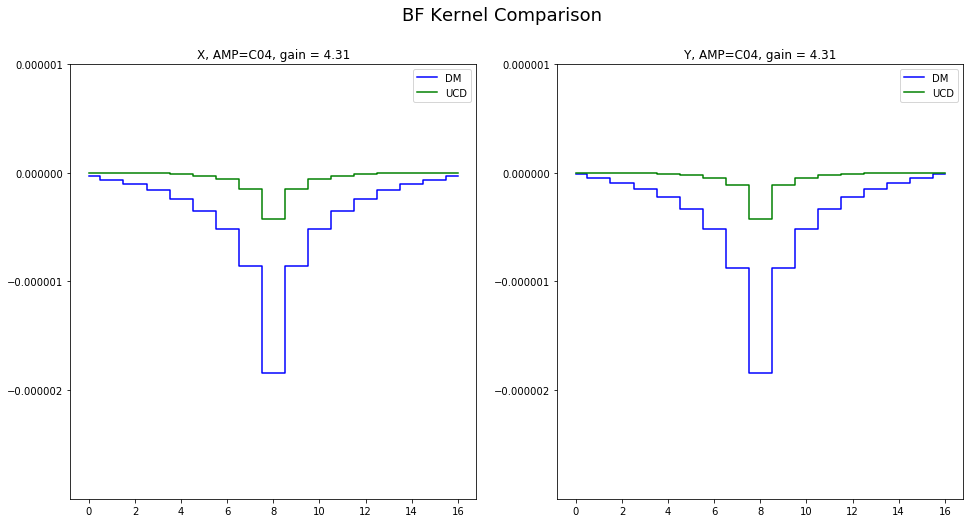

In [30]:
key = 'C04'
plt.figure(figsize=(16,8))
plt.suptitle("BF Kernel Comparison", fontsize = 18)
plt.subplots_adjust(hspace=0.8)
 
ax1 = plt.subplot(1,2,1)
ax1.set_title('X, AMP=%s, gain = %.2f'%(key,gain_data[key])) 
ax1.set_ylim(-3.0E-6,1.0E-6)
ax1.set_yticks([-2.0E-6,-1.0E-6,0.0,1.0E-6])
ax1.plot(ucd_bf_kernel[key][:,8], color='blue', drawstyle='steps-mid', label='DM')
ax1.plot(kernel.kernel[2:19,10], color='green', drawstyle='steps-mid', label='UCD')
ax1.legend()
ax2 = plt.subplot(1,2,2)
ax2.set_title('Y, AMP=%s, gain = %.2f'%(key,gain_data[key])) 
ax2.set_ylim(-3.0E-6,1.0E-6)
ax2.set_yticks([-2.0E-6,-1.0E-6,0.0,1.0E-6])
ax2.plot(ucd_bf_kernel[key][8,:], color='blue', drawstyle='steps-mid', label='DM')
ax2.plot(kernel.kernel[10,2:19], color='green', drawstyle='steps-mid', label='UCD')
ax2.legend()
plt.savefig('BF_Kernel_Comparison_29Aug18.pdf')
plt.show()

These don't agree very well at all.  My hypothesis is that it is a gain issue, since if I divide the DM values by the gain of 4.31 then they agree pretty well.  I suspect that this is just a difference of whether the correction is applied before or after the gain correction.


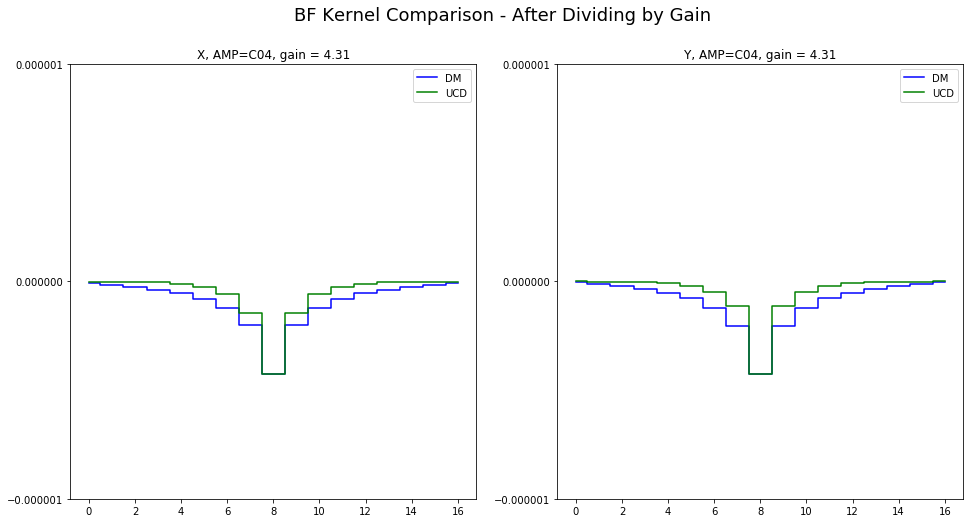

In [33]:
key = 'C04'
plt.figure(figsize=(16,8))
plt.suptitle("BF Kernel Comparison - After Dividing by Gain", fontsize = 18)
plt.subplots_adjust(hspace=0.8)
 
ax1 = plt.subplot(1,2,1)
ax1.set_title('X, AMP=%s, gain = %.2f'%(key,gain_data[key])) 
ax1.set_ylim(-1.0E-6,1.0E-6)
ax1.set_yticks([-1.0E-6,0.0,1.0E-6])
ax1.plot(ucd_bf_kernel[key][:,8]/gain_data[key], color='blue', drawstyle='steps-mid', label='DM')
ax1.plot(kernel.kernel[2:19,10], color='green', drawstyle='steps-mid', label='UCD')
ax1.legend()
ax2 = plt.subplot(1,2,2)
ax2.set_title('Y, AMP=%s, gain = %.2f'%(key,gain_data[key])) 
ax2.set_ylim(-1.0E-6,1.0E-6)
ax2.set_yticks([-1.0E-6,0.0,1.0E-6])
ax2.plot(ucd_bf_kernel[key][8,:]/gain_data[key], color='blue', drawstyle='steps-mid', label='DM')
ax2.plot(kernel.kernel[10,2:19], color='green', drawstyle='steps-mid', label='UCD')
ax2.legend()
plt.savefig('BF_Kernel_Comparison_Gain_29Aug18.pdf')
plt.show()